In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
from tensorflow import keras
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
from tensorflow.keras.losses import Huber
from sklearn.preprocessing import MinMaxScaler

2023-12-12 12:17:50.141211: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-12 12:17:50.369023: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-12 12:17:51.247485: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-12-12 12:17:51.247651: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinf

In [2]:
# Baca data Excel
df_train = pd.read_excel('lomba/train_prepro.xlsx', index_col=0)
df_test = pd.read_excel('lomba/test_prepro.xlsx',  index_col=0)

In [4]:
df_train

,Make,Vehicle Class,Engine Size(L),Cylinders,Transmission,Fuel Type,City,HighWay,Combination,CO2 Emissions(g/km)
Id,,,,,,,,,,
1,7,6,0.526316,0.500000,3,3,0.222910,0.210274,0.263047,306.0
2,4,6,0.905263,0.358668,3,1,0.703560,1.000000,1.000000,283.0
3,2,10,0.715789,0.358668,23,4,0.043860,0.069521,0.437581,329.0
4,11,11,0.418238,0.166667,13,3,0.395769,0.544521,0.437581,270.0
5,1,3,0.421053,0.500000,13,4,0.519866,0.205479,0.484838,193.0
...,...,...,...,...,...,...,...,...,...,...
137137,2,10,0.418238,0.833333,15,4,0.869711,0.263699,0.775035,275.0
137138,9,9,0.105263,0.166667,23,3,0.167441,0.029795,0.137870,166.0
137139,17,2,0.168421,0.166667,17,3,0.077141,0.286986,0.188999,181.0


In [5]:
df_test

,Make,Vehicle Class,Engine Size(L),Cylinders,Transmission,Fuel Type,City,HighWay,Combination
Id,,,,,,,,,
137142,3,2,0.547368,0.358668,15,3,0.402993,0.060616,0.329337
137143,7,15,0.568421,0.500000,13,3,0.544634,0.492466,0.635755
137144,16,11,1.000000,0.358668,19,3,0.632095,0.352397,0.636812
137145,14,2,0.757895,0.358668,15,4,0.433437,0.544521,0.577221
137146,2,12,0.715789,0.833333,15,4,1.000000,0.655822,1.000000
...,...,...,...,...,...,...,...,...,...
195913,11,11,0.484211,0.358668,3,3,0.473426,0.715753,0.685825
195914,7,11,0.126316,0.166667,13,3,0.159701,0.226027,0.222849
195915,4,12,0.526316,0.358668,3,3,0.373839,0.376712,0.453808


In [6]:
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Pisahkan fitur dan target
X_train_scaled = df_train.iloc[:, :-1]
y_train_scaled = df_train.iloc[:, -1]

data_X_train_scaled = scaler_X.fit_transform(X_train_scaled)
data_y_train_scaled = scaler_y.fit_transform(np.array(y_train_scaled).reshape(-1, 1))

data_test_scaled = scaler_X.fit_transform(df_test)

In [58]:
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
def modelnya():
    model = Sequential()
    model.add(Dense(64, input_dim=data_X_train_scaled.shape[1]))
    model.add(Dense(32, kernel_regularizer='l2'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='linear'))
    optimizer = Adam(learning_rate=0.001)  # Ganti optimizer dan nilai learning_rate sesuai kebutuhan

    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=[RootMeanSquaredError()])
    return model


In [59]:
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
model = modelnya()
model.summary()
  # Definisikan callbacks
callbacks = [
        ModelCheckpoint(f'./logs/lomba-nn/best_model.h5', monitor='loss', save_best_only=True),
        TensorBoard(log_dir=f'./logs/lomba-nn', histogram_freq=1, write_graph=True, write_images=True)
    
    ]
history = model.fit(data_X_train_scaled, data_y_train_scaled, batch_size=128, epochs=20,
                        verbose=2, callbacks=callbacks, workers=-1)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 64)                640       
                                                                 
 dense_29 (Dense)            (None, 32)                2080      
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dense_30 (Dense)            (None, 1)                 33        
                                                                 
Total params: 2,753
Trainable params: 2,753
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
1072/1072 - 2s - loss: 0.4454 - root_mean_squared_error: 0.2033 - 2s/epoch - 2ms/step
Epoch 2/20
1072/1072 - 2s - loss: 0.4068 - root_mean_squared_error: 0.1430 - 2s/epoch 

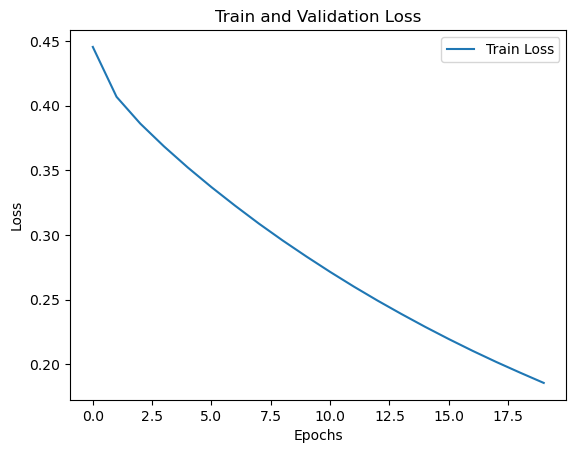

In [60]:
# Plot Loss dan Validation Loss
plt.plot(history.history['loss'], label='Train Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Train and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

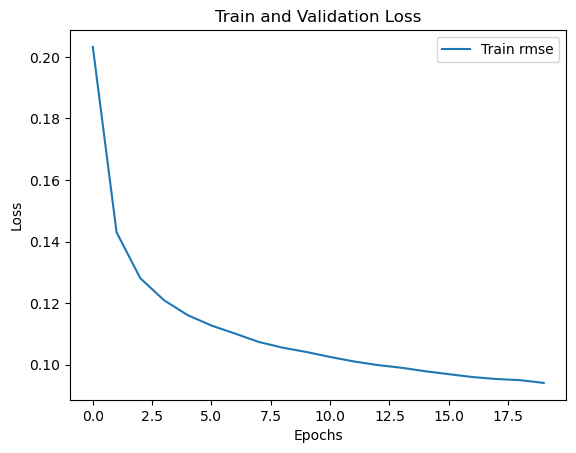

In [61]:
# Plot Loss dan Validation Loss
plt.plot(history.history['root_mean_squared_error'], label='Train rmse')
# plt.plot(history.history['val_root_mean_squared_error'], label='Validation rmse')
plt.title('Train and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [62]:
import tensorflow as tf
model_best = tf.keras.models.load_model(f'logs/lomba-nn/best_model.h5')

In [63]:
# Prediksi menggunakan model
predictions = model.predict(data_test_scaled)

1837/1837 [==============================] - 1s 754us/step


In [64]:
balikan_prediksi = scaler_y.inverse_transform(predictions).astype(int)
predictions_float = balikan_prediksi.astype(float)

In [65]:
predictions_float.shape , df_test.shape

((58776, 1), (58776, 9))

In [66]:
df_test_no_index  = df_test.reset_index(drop=True)
df_test_no_index

,Make,Vehicle Class,Engine Size(L),Cylinders,Transmission,Fuel Type,City,HighWay,Combination
0,3,2,0.547368,0.358668,15,3,0.402993,0.060616,0.329337
1,7,15,0.568421,0.500000,13,3,0.544634,0.492466,0.635755
2,16,11,1.000000,0.358668,19,3,0.632095,0.352397,0.636812
3,14,2,0.757895,0.358668,15,4,0.433437,0.544521,0.577221
4,2,12,0.715789,0.833333,15,4,1.000000,0.655822,1.000000
...,...,...,...,...,...,...,...,...,...
58771,11,11,0.484211,0.358668,3,3,0.473426,0.715753,0.685825
58772,7,11,0.126316,0.166667,13,3,0.159701,0.226027,0.222849
58773,4,12,0.526316,0.358668,3,3,0.373839,0.376712,0.453808
58774,7,11,0.842105,0.833333,13,3,0.217234,0.157192,0.234485


In [67]:
df_test

,Make,Vehicle Class,Engine Size(L),Cylinders,Transmission,Fuel Type,City,HighWay,Combination
Id,,,,,,,,,
137142,3,2,0.547368,0.358668,15,3,0.402993,0.060616,0.329337
137143,7,15,0.568421,0.500000,13,3,0.544634,0.492466,0.635755
137144,16,11,1.000000,0.358668,19,3,0.632095,0.352397,0.636812
137145,14,2,0.757895,0.358668,15,4,0.433437,0.544521,0.577221
137146,2,12,0.715789,0.833333,15,4,1.000000,0.655822,1.000000
...,...,...,...,...,...,...,...,...,...
195913,11,11,0.484211,0.358668,3,3,0.473426,0.715753,0.685825
195914,7,11,0.126316,0.166667,13,3,0.159701,0.226027,0.222849
195915,4,12,0.526316,0.358668,3,3,0.373839,0.376712,0.453808


In [68]:
# Gabungkan hasil prediksi dengan DataFrame pengujian
result_df = pd.DataFrame(predictions_float, columns=['Predicted CO2 Emissions(g/km)'])
result_df
final_result = pd.concat([df_test_no_index, result_df], axis=1)
final_result

,Make,Vehicle Class,Engine Size(L),Cylinders,Transmission,Fuel Type,City,HighWay,Combination,Predicted CO2 Emissions(g/km)
0,3,2,0.547368,0.358668,15,3,0.402993,0.060616,0.329337,242.0
1,7,15,0.568421,0.500000,13,3,0.544634,0.492466,0.635755,308.0
2,16,11,1.000000,0.358668,19,3,0.632095,0.352397,0.636812,296.0
3,14,2,0.757895,0.358668,15,4,0.433437,0.544521,0.577221,267.0
4,2,12,0.715789,0.833333,15,4,1.000000,0.655822,1.000000,360.0
...,...,...,...,...,...,...,...,...,...,...
58771,11,11,0.484211,0.358668,3,3,0.473426,0.715753,0.685825,297.0
58772,7,11,0.126316,0.166667,13,3,0.159701,0.226027,0.222849,220.0
58773,4,12,0.526316,0.358668,3,3,0.373839,0.376712,0.453808,297.0
58774,7,11,0.842105,0.833333,13,3,0.217234,0.157192,0.234485,321.0


In [69]:
result_df

,Predicted CO2 Emissions(g/km)
0,242.0
1,308.0
2,296.0
3,267.0
4,360.0
...,...
58771,297.0
58772,220.0
58773,297.0
58774,321.0
